<a name='top'></a>Contents
===
- [Introduction](#intro)

- [Libraries](#libraries)

- [Functions](#functions)

- [Top References](#top_references)
    - [BW](#bw)
        - [Open BW dataset](#open_bw)
        - [Customize BW dataset](#customize_bw)
    - [Adwords](#adwords)
        - [Open Adwords dataset](#open_ads)
        - [Customize Ads dataset](#customize_ads)
    - [Merge BW and Adwords data](#merge_bw_ads)
    - [Select Top References](#top_50)
    
- [References url](#url)
    - [Open References url dataset](#open_url)
    - [Merge References url and Top 50 references](#merge_url_top50)
    - [Customize References url dataset](#customize_url)

- [Save dataframe](#save_data)

------------------------------------------------------------------------------------------------------
<a name='intro'></a>
# Introduction

The main purpose of this study is to select the most relevant references that achieve the following requirements:
   - Net_Incomes > 0€
   - At least more than 30 days with a transaction
   - At least more than 30 days of exposition in Adwords
   - Cost > 0€ 

For this study, it will be used two data sources:
   - **BW**: these database contains the references id, date feature, net incomes and units sold per item. 
   - **Adwords**: these database contains advertisment data such as reference id, campaign, currency, etc.
   

<br>After that selection, it will merge that data with its related ulr in order to use this dataframe in incoming scripts.
   


-----------------------------------------------------------------------------------
<a name='libraries'></a>
# Libraries

First of all, it is necessary to import the required libraries to develop all the steps correctly of this notebook.

In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from datetime import datetime
%matplotlib inline


#import filter warnings
import warnings
warnings.filterwarnings('ignore')


#display a maximum of 500 columns and rows
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

#set directory of work
path = '/home/miguel/my_project_python/my_project_env/tfm/shopping'
os.chdir(path)

-----------------------------------------------------------------------------------------------
<a name='functions'></a>
# Functions
In this chapter is run the functions used in this notebook.

In [2]:
def open_bw(file, path_file):
    
    #open the file xlsx    
    df_bw = pd.read_csv(path_file + file, delimiter = ';', error_bad_lines=False)
    
    #rename the file columns correctly
    df_bw = df_bw.rename(index=str, columns={'Referencia':'Reference', 'T Día natural':'Date', 
                                             'Valor neto pedidos':'Net_Incomes', 
                                             'Cantidad en unidades (pedidos)':'Units_sold'})
        
    #replace
    df_bw['Net_Incomes'] = df_bw['Net_Incomes'].str.replace('.','').str.replace(',','.').astype(float)
    
    #date columns to specific datetime format
    df_bw['Date'] = pd.to_datetime(df_bw['Date'], format = '%d.%m.%Y')
    
    return df_bw

----------------------------------------------------------------------------------
<a name='top_references'></a>
# Top References

In this section, it is analyzed the whole enterprise inventory with the purpose of selecting **the most sold references in the last 6 months** (from 1 october 2018 to 31 march 2019).

<br>This references has also to accomplish the requirementes explained before:   
   - Net_Incomes > 0€ in BW
   - At least more than 30 days with a transaction
   - At least more than 30 days of exposition in Adwords
   - Cost > 0€ in Adwords

******************************************************************************************************************
<a name='bw'></a>

## BW

In this section, it is loaded the transactional information from the company in order to get these data:
   - Reference: sku id
   - Date: date of the transaction
   - Net_Incomes: net incomes per reference
   - Units_sold: quantity of units sold per reference




<a name='open_bw'></a> 

### Open BW dataset
Firstly, it is loaded the BW data with a function

In [3]:
#open the file
df_bw = open_bw('BW.csv', './data/raw/bw/')

After that, it is checked the data:

In [4]:
df_bw.head(5)

,Reference,Name,Date,Net_Incomes,Units_sold
0,4623,"ESPEJO PUERTA ""LCC"" BLANCO POLIETILENO",2017-09-11,18.93,1
1,4623,"ESPEJO PUERTA ""LCC"" BLANCO POLIETILENO",2017-09-21,18.93,1
2,4623,"ESPEJO PUERTA ""LCC"" BLANCO POLIETILENO",2017-10-08,16.08,1
3,4623,"ESPEJO PUERTA ""LCC"" BLANCO POLIETILENO",2017-10-16,16.08,1
4,4623,"ESPEJO PUERTA ""LCC"" BLANCO POLIETILENO",2017-10-21,16.08,1


In [5]:
df_bw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37614 entries, 0 to 37613
Data columns (total 5 columns):
Reference      37614 non-null int64
Name           37614 non-null object
Date           37614 non-null datetime64[ns]
Net_Incomes    37614 non-null float64
Units_sold     37614 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.7+ MB


In [6]:
df_bw.shape

(37614, 5)

<a name='customize_bw'></a> 

### Customize BW dataset
After checking that the dataset is all right, it is necessary to filter that information by:
    - Date: from 2018.10.01 to 2019.31.03
    - Groupby: Reference
    - Net Incomes: > 0€
    - Day transactions: > 30 days

In [7]:
#filter information from 10 oct 2018
df_bw_filter = df_bw[df_bw['Date']>='10.01.2018']

#group by Reference 
df_bw_groupby = df_bw.groupby(by='Reference').agg({'Date':'count', 'Units_sold':'sum','Net_Incomes':'sum'}).sort_values(by='Units_sold',ascending=False)

#filter net incomes over a 0€ and a minimum of 30 days with a transaction
df_bw_groupby = df_bw_groupby[(df_bw_groupby['Net_Incomes']!=0) & (df_bw_groupby['Date']>=30)]

Check the new dataframe:

In [8]:
df_bw_groupby.head(5)

,Date,Units_sold,Net_Incomes
Reference,,,
8141600,55,416,8533.68
82462,38,363,11208.61
82035,82,336,8336.26
61119,172,263,11613.23
95203,46,182,2097.29


In [9]:
df_bw_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 8141600 to 122541
Data columns (total 3 columns):
Date           137 non-null int64
Units_sold     137 non-null int64
Net_Incomes    137 non-null float64
dtypes: float64(1), int64(2)
memory usage: 4.3 KB


In [10]:
df_bw_groupby.shape

(137, 3)

******************************************************************************************************************
<a name='adwords'></a> 
## Adwords
After having selected the suitable transactional information from BW data, it is necessary to load Adwords dataset in order to filter the information by the last two requirements:
   - At least more than 30 days of exposition in Adwords
   - Cost > 0€ in Adwords

<a name='open_ads'></a> 
### Open Adwords dataset
Open and check the dataset for this period

In [11]:
#establish directory
path_ads_raw = './data/raw/adwords/'

#open adwords data for this period
df_ads_2018_19 = pd.read_csv(path_ads_raw + 'TFM_Datos_2018_19.csv', sep=';')

#head
df_ads_2018_19.head(5)

,ID de producto,Campaña,ID de la campaña,Tipo de producto (primer nivel),Tipo de producto (segundo nivel),Día,Etiqueta personalizada 1,CPC máximo predeterminado del grupo de anuncios,Moneda,Impresiones,Clics,CTR,CPC medio,Coste,Conversiones,Todas las conversiones,Valor de conv.,Valor de todas las conversiones,Valor conv./coste
0,123624,Shop_Cocina y comedor_N1_Y18_W37,1559515409,cocina y comedor,tazas de café y mugs,12/10/2018,10,"0,15",EUR,1,0,"0,00 %","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
1,107553,Shop_Smart_Lámparas_Y18_W45,1623248621,lámparas e iluminación,lámparas de techo,31/01/2019,40,"0,01",EUR,2,0,"0,00 %","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
2,87810,Shop_Navidad_Estrellas de navidad_Y18_W12,1323457572,decoración de navidad,estrellas de navidad,17/10/2018,20,"0,2",EUR,1,0,"0,00 %","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
3,105114,Shop_Decoración_N1_Y18_W37,1559890739,decoración para tu casa,figuras decorativas,25/10/2018,30,"0,15",EUR,4,0,"0,00 %","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
4,111017,Shop_Navidad_Portavelas navideños_Y18_W12,1323682318,decoración de navidad,portavelas navideños,21/10/2018,20,"0,2",EUR,8,0,"0,00 %","0,00","0,00","0,00","0,00","0,00","0,00","0,00"


Check data

In [12]:
df_ads_2018_19.shape

(447539, 19)

In [13]:
df_ads_2018_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447539 entries, 0 to 447538
Data columns (total 19 columns):
ID de producto                                     447539 non-null int64
Campaña                                            447539 non-null object
ID de la campaña                                   447539 non-null int64
Tipo de producto (primer nivel)                    447539 non-null object
Tipo de producto (segundo nivel)                   447539 non-null object
Día                                                447539 non-null object
Etiqueta personalizada 1                           447539 non-null object
CPC máximo predeterminado del grupo de anuncios    447539 non-null object
Moneda                                             447539 non-null object
Impresiones                                        447539 non-null int64
Clics                                              447539 non-null int64
CTR                                                447539 non-null object
CPC m

After checking the file, let making data wrangling and check again the data

In [14]:
#select columns of interest
columns_interest_adwords = ['ID de producto', 'Día', 'Coste', 'Impresiones']
df_ads = df_ads_2018_19[columns_interest_adwords]

#rename columns
df_ads = df_ads.rename(index=str, columns={'ID de producto':'Reference', 'Día':'Date', 'Coste':'Cost', 'Impresiones':'Impresions'})

#string to datetime and float
df_ads['Date'] = pd.to_datetime(df_ads['Date'], format = '%d/%m/%Y')
df_ads['Cost'] = df_ads['Cost'].str.replace(',','.').astype(float)

#groupby reference
df_ads_groupby = df_ads.groupby(by='Reference').agg({'Date':'count', 'Cost':'sum', 'Impresions':'sum'}).sort_values(by='Cost',ascending=False)

Head the dataframe

In [15]:
df_ads_groupby.head(5)

,Date,Cost,Impresions
Reference,,,
64534,182,2701.53,1165107
123838,132,1803.89,398687
98064,112,1427.50,482281
103808,174,1370.33,521766
64531,185,1365.16,562220


In [16]:
df_ads_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9248 entries, 64534 to 105812
Data columns (total 3 columns):
Date          9248 non-null int64
Cost          9248 non-null float64
Impresions    9248 non-null int64
dtypes: float64(1), int64(2)
memory usage: 289.0 KB


<a name='customize_ads'></a> 
### Customize Ads dataset


After this last step, the data is filtered:

In [17]:
df_ads_groupby = df_ads_groupby[(df_ads_groupby['Cost']!=0) & (df_ads_groupby['Date']>=30)]

******************************************************************************************************************
<a name='merge_bw_ads'></a> 

## Merge BW and Adwords data
In this section, it is merged and clean in a proper way the information got it previosly.

In [18]:
#merge data from both dataframes
merge_bw_ads = df_bw_groupby.merge(df_ads_groupby,
           how='inner',
           left_on=['Reference'],
           right_on=['Reference'])

#reset index
merge_bw_ads = merge_bw_ads.reset_index()

#sort values by Units sold and show the top 50
merge_bw_ads = merge_bw_ads.sort_values(by=['Units_sold'], ascending=False)

In [19]:
merge_bw_ads.shape

(112, 7)

******************************************************************************************************************
<a name='top_50'></a> 

## Select Top References
After that, it is selected the references that accomplish 2/3 of units sold from this specific selection. 

In [20]:
#reset index
merge_bw_ads.reset_index(inplace = True)

#create cumpercentage column
merge_bw_ads['Cumpercentage'] = merge_bw_ads['Units_sold'].cumsum()/merge_bw_ads['Units_sold'].sum()*100

#select references
references_selected = np.min(merge_bw_ads.loc[merge_bw_ads['Cumpercentage'] > 66.7, 'index'])

#print
print('The references needed to achieve 66.7 of cumpercantege is',references_selected)


The references needed to achieve 66.7 of cumpercantege is 50


**This is the final distribution**

<Figure size 72000x720000 with 0 Axes>

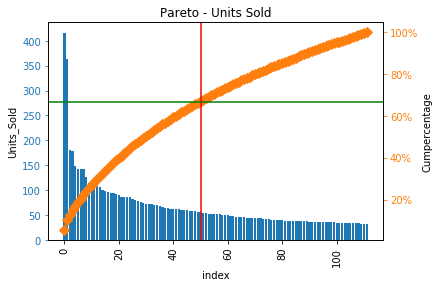

In [21]:
#set figure
plt.figure(figsize=(1000,10000))
fig, ax = plt.subplots()

#set xticks
ax.bar(merge_bw_ads.index, merge_bw_ads['Units_sold'], color='C0')
plt.xticks(rotation='vertical')
ax2 = ax.twinx()
ax2.plot(merge_bw_ads.index, merge_bw_ads['Cumpercentage'], color='C1', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

#set params
ax.tick_params(axis='y', direction='out', colors='C0')
ax2.tick_params(axis='y', direction='out', colors='C1')

#set title for the plot and labels
plt.title('Pareto - Units Sold')

ax.set_xlabel('index')
ax.set_ylabel('Units_Sold')
ax2.set_ylabel('Cumpercentage')

#ax.set_title('Pareto - Units Sold')
#ax2.set_title('ax2 title')
plt.axvline(round(np.min(merge_bw_ads.loc[merge_bw_ads['Cumpercentage'] > 66.7, 'index']),2), color='r')
plt.axhline(66.7, color='green')


#show
plt.show()
fig.savefig('./img/pareto_units_sold.png', dpi = 180)

It is saved as dataframe the data of this 50 references

In [22]:
#select just reference column
df_top_50 = merge_bw_ads[['Reference']].head(references_selected)

#head
df_top_50

,Reference
0,8141600
1,82462
2,82466
3,8146000
4,122539
5,123838
6,61096
7,89051
8,61731
9,48905


In [23]:
df_top_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 1 columns):
Reference    50 non-null int64
dtypes: int64(1)
memory usage: 484.0 bytes


In [24]:
df_top_50.shape

(50, 1)

<a name='url'></a> 

# Reference url
Next step, it is going to be joined the top 50 references gathered with their related url.

<a name='open_url'></a> 

## Open References url dataset
Open and check the url dataset

In [25]:
#select path
path_url_raw = './data/raw/url/'

#open 'reference url' dataset
df_url = pd.read_csv(path_url_raw + 'references_url.csv', delimiter = ';', error_bad_lines=False)

#head
df_url.head(5)

,sku,URL
0,1256,/maceta-ceramica-garden-20-cm.html
1,1258,/planta-artificial-macetero-verde.html
2,1264,/maceta-ceramica-garden-40-cm.html
3,1265,/maceta-ceramica-garden-41-cm.html
4,1267,/maceta-ceramica-garden-28-cm.html


In [26]:
df_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30548 entries, 0 to 30547
Data columns (total 2 columns):
sku    30548 non-null int64
URL    30548 non-null object
dtypes: int64(1), object(1)
memory usage: 477.4+ KB


In [27]:
df_url.shape

(30548, 2)

<a name='merge_url_top50'></a> 
## Merge References url and Top 50 references
It is merged the url dataframe with the top 50 references dataframe

In [28]:
df_url['sku'] = df_url['sku'].astype(float)


#merge data
merge_url = df_url.merge(df_top_50,
           how='inner',
           left_on=['sku'],
           right_on=['Reference'])

#select column of interest
columns_interest = ['Reference', 'URL']
merge_url = merge_url[columns_interest]

#head
merge_url

,Reference,URL
0,29300,/lampara-mesita-de-noche-oriental-blanco-ceram...
1,30655,/banqueta-pie-de-cama-romantico-blanco-metal-d...
2,38697,/belen-navidad-moderno-multicolor-resina-decor...
3,48329,/mesita-auxiliar-industrial-blanco-metal-salon...
4,48624,/biombo-plegable-oriental-blanco-madera-salon-...
5,48841,/espejo-pared-nordico-blanco-pu-salon-fantasy....
6,48905,/mesita-auxiliar-moderno-negro-madera-salon-fa...
7,49809,/farol-portavelas-metal-blanco-21033.html
8,49918,/perchero-suelo-metal-negro-21504.html
9,51136,/consola-3-cajones-y-4-puertas-oriental-negro-...


In [29]:
merge_url.shape

(50, 2)

<a name='save_data'></a> 
# Save dataframe
Finally, it is saved the last dataframe created with the following informations:
    - Reference
    - url

In [30]:
#set directory
path = './data/customize/top_50/'

#save data
merge_url.to_csv(path + 'references_url.csv', sep='\t')